In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score as BACC
import tensorflow as tf
import keras.backend as K

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#### DATA PROCESSING ####
def load_dias():
    X = np.load('/content/drive/MyDrive/ML/Lab4/Xtrain_Classification2.npy') #10629 x 2352 2D array
    y = np.load('/content/drive/MyDrive/ML/Lab4/ytrain_Classification2.npy') #10629 x 1 1D array
    X_t = np.load('/content/drive/MyDrive/ML/Lab4/Xtest_Classification2.npy') #2658 x 2352 2D array
    return X, y, X_t

def load_dudu():
    X = np.load('Xtrain_Classification2.npy') #10629 x 2352 2D array
    y = np.load('ytrain_Classification2.npy') #10629 x 1 1D array
    X_t = np.load('Xtest_Classification2.npy') #2658 x 2352 2D array
    return X, y, X_t

def data_pre_processing(X, X_t):
    Xscaled = (X).astype('float32')/np.max(X) #Scale down data [0,1]
    Xscaled_test = (X_t).astype('float32')/np.max(X)
    return Xscaled, Xscaled_test

def encoding(Xscaled, Xscaled_test):
    train_labels = keras.utils.to_categorical(y,num_classes=6) #One-hot enconding
    train_images = np.reshape(Xscaled, (len(Xscaled[:,0]),28,28,3)) #4D array. number of images x width x height x color
    test_images = np.reshape(Xscaled_test, (len(Xscaled_test[:,0]), 28, 28, 3))
    return train_labels, train_images, test_images

def shuffling(Xscaled, train_images, train_labels):
    permutation = np.random.permutation(len(Xscaled[:,0])) #No shuffling done for test images
    train_images_s = train_images[permutation]
    train_labels_s = train_labels[permutation]
    return train_images_s, train_labels_s

def number_per_class(y):
    print('Número de imagens da  classe 0:', np.count_nonzero(y==0))
    print('Número de imagens da classe 1:', np.count_nonzero(y==1))
    print('Número de imagens da classe 2:', np.count_nonzero(y==2))
    print('Número de imagens da classe 3:', np.count_nonzero(y==3))
    print('Número de imagens da classe 4:', np.count_nonzero(y==4))
    print('Número de imagens da classe 5:', np.count_nonzero(y==5))

X, y, X_t = load_dias()
print(X.shape,y.shape, X_t.shape)
Xscaled, Xscaled_test = data_pre_processing(X, X_t)
train_labels, train_images, test_images = encoding(Xscaled, Xscaled_test)
train_images_s, train_labels_s = shuffling(Xscaled, train_images, train_labels)
X_train, X_validation, y_train, y_validation = train_test_split(train_images_s, train_labels_s, test_size=0.2)

#### METRICS ####

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)[1]
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)[1]
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)[1]
    precision = true_positives / (predicted_positives)
    recall = true_positives / (possible_positives)
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

def bacc(cnn_model, X, y_real):
    y_pred = cnn_model.predict(X_validation)
    #Convert one-hot encoded true/predictions labels to categorical labels
    y_true_labels = np.argmax(y_validation, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    bacc = BACC(y_true_labels, y_pred_labels)
    return bacc

#### CONVOLUTION NEURAL NETWORK ####

def Improved_CNN():
    #Replaced AveragePooling2D with MaxPooling2D for better feature selection.
    #Simplified by fewer dropout layers.
    cnn = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 3)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(6, activation='softmax')
    ])

    cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.F1Score()])
    return cnn

def Improved_CNN2():
    #Replaced AveragePooling2D with MaxPooling2D for better feature selection.
    #Simplified by fewer dropout layers.
    cnn = keras.Sequential([
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2',padding="same"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu',activity_regularizer='l2',bias_regularizer='l2'),
        keras.layers.Dense(6, activation='softmax')
    ])

    cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.F1Score()])
    return cnn

def Improved_CNN3():
    cnn = keras.Sequential([
      keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3),kernel_regularizer='l2'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer='l2',padding="same"),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Dropout(0.3),
      keras.layers.Flatten(),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(512, activation='relu',activity_regularizer='l2',bias_regularizer='l2'),
      keras.layers.Dense(6, activation='softmax')
    ])

    cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.F1Score()])
    return cnn


##### PLOT  ######

def plot(history):
    plt.figure(figsize=(15, 5))  # Increase the figure size

    # Create the first subplot (Loss)
    plt.subplot(2, 2, 1)  # Create a subplot with 1 row and 3 columns, and select the first subplot
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Create the second subplot (F1 Score)
    plt.subplot(2, 2, 2)  # Select the second subplot
    plt.plot(history.history['f1_score'], 'g', label='Training F1 Score')
    plt.plot(history.history['val_f1_score'], 'r', label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

def check_results(history):
    plot(history)
    print("Train - Loss: {:.4f}".format(history.history['loss'][-1]))
    print("Test  - Val Loss: {:.4f}".format(np.mean(history.history['val_loss'][-1])))
    train_f1_score = np.mean(history.history['f1_score'])
    val_f1_score = np.mean(history.history['val_f1_score'])
    print("Train - Mean F1 Score: {:.4f}".format(train_f1_score))
    print("Test - Mean Val F1 Score: {:.4f}".format(val_f1_score))

from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

##### DATA BALANCE GENERATOR  ######
def data_balance_generator(Xtrain, train_labels, num_classes):
    Xtrain = Xtrain.reshape(-1, 28, 28, 3) # Reshape the input data

    train_labels = np.argmax(train_labels, axis=1) # Convert one-hot encoded labels to categorical labels (0 to num_classes-1)
    train_labels = tf.cast(train_labels, dtype=tf.float32)

    train_labels = keras.utils.to_categorical(train_labels, num_classes) # Reshape the labels back to one-hot encoding

    # Use RandomOverSampler to balance the dataset
    ros = RandomOverSampler(sampling_strategy='auto')
    X_resampled, y_resampled = ros.fit_resample(Xtrain.reshape(-1, 28 * 28 * 3), train_labels)

    X_resampled = X_resampled.reshape(-1, 28, 28, 3) # Reshape X_resampled back to its original shape

    return X_resampled, y_resampled

##### TRAINING ######
def learning_rate_scheduler_function(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * 0.95  # Adjust the rate as needed

lr_callback = LearningRateScheduler(learning_rate_scheduler_function)

def class_weights(y_train):
    y_train_int = tf.argmax(y_train, axis=1)
    y_train_int_np = y_train_int.numpy()
    weights = compute_class_weight('balanced', classes=np.unique(y_train_int_np), y=y_train_int_np)
    class_weights = {i: weights[i] for i in range(len(weights))}
    return class_weights

def train_model_class_weights(cnn, X_train, y_train, X_validation, y_validation, in_verbose):
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)  # Cast y_train to float32
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                      batch_size=512, epochs=200, shuffle=True, verbose=in_verbose,
                      callbacks=[early_stop, lr_callback], class_weight=class_weights(y_train))
    return history

def train_model_ag2(cnn, X_train, y_train, X_validation, y_validation, in_verbose):
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)  # Cast y_train to float32
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                      batch_size=512, epochs=200, shuffle=True, verbose=in_verbose,
                      callbacks=[early_stop, lr_callback])
    return history

models = []

#Model 1 with oversample
def model_1(X_train, y_train):
    cnn_model1 = Improved_CNN()
    X_train_ag, y_train_ag = data_balance_generator(X_train, y_train, 6)
    cnn_model1_history = train_model_ag2(cnn_model1, X_train_ag, y_train_ag, X_validation, y_validation, 0)
    return cnn_model1, cnn_model1_history


#Model 2 with oversample
def model_2(X_train, y_train):
    cnn_model2 = Improved_CNN2()
    X_train_ag, y_train_ag = data_balance_generator(X_train, y_train, 6)
    cnn_model2_history = train_model_ag2(cnn_model2, X_train_ag, y_train_ag, X_validation, y_validation, 0)
    return cnn_model2, cnn_model2_history

#Model 1 with class weights
def model_3(X_train, y_train):
    cnn_model3 = Improved_CNN()
    cnn_model3_history = train_model_class_weights(cnn_model3, X_train, y_train, X_validation, y_validation, 0)
    return cnn_model3, cnn_model3_history


#Model 2 with class weights
def model_4(X_train, y_train):
    cnn_model4 = Improved_CNN2()
    cnn_model4_history = train_model_class_weights(cnn_model4, X_train, y_train, X_validation, y_validation, 0)
    return cnn_model4, cnn_model4_history

#Model 5 with class weights
def model_5(X_train, y_train):
    cnn_model5 = Improved_CNN3()
    cnn_model5_history = train_model_class_weights(cnn_model5, X_train, y_train, X_validation, y_validation, 0)
    return cnn_model5, cnn_model5_history


(10629, 2352) (10629,) (2658, 2352)


In [ ]:
cnn_model_1, cnn_model1_history = model_1(X_train, y_train)

67/67 [==============================] - 0s 6ms/step - loss: 0.3713 - categorical_accuracy: 0.8100 - f1_score: 0.7611
Test categorical: 0.8099717497825623
Test f1: [0.84481853 0.517179   0.58536583 0.8870392  0.8564705  0.8755556 ]
Train - Loss: 0.2757
Test  - Val Loss: 0.3994
Train - Mean F1 Score: 0.8064
Test - Mean Val F1 Score: 0.6638
67/67 [==============================] - 0s 3ms/step
Balanced Accuracy: 0.8606071408030979


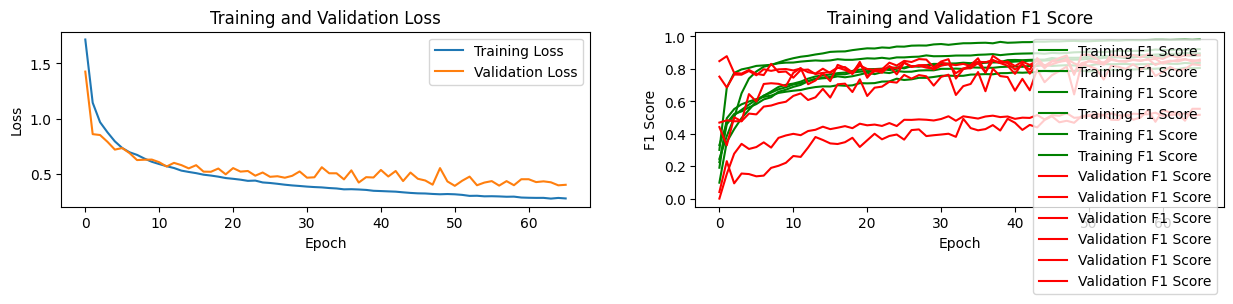

In [ ]:
test_cnn_model_1 = cnn_model_1.evaluate(X_validation, y_validation, verbose=1)
print('Test categorical:', test_cnn_model_1[1])
print('Test f1:', test_cnn_model_1[2])

check_results(cnn_model1_history)
bacc_final = bacc(cnn_model_1, X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)

In [3]:
cnn_model_2, cnn_model2_history = model_2(X_train, y_train)

67/67 [==============================] - 1s 7ms/step - loss: 0.4223 - categorical_accuracy: 0.8989 - f1_score: 0.8485
Test categorical: 0.898871123790741
Test f1: [0.9182575  0.5990338  0.74285716 0.9616161  0.91978604 0.94949496]
Train - Loss: 0.2237
Test  - Val Loss: 0.4242
Train - Mean F1 Score: 0.9639
Test - Mean Val F1 Score: 0.8217
67/67 [==============================] - 0s 3ms/step
Balanced Accuracy: 0.85356823073178


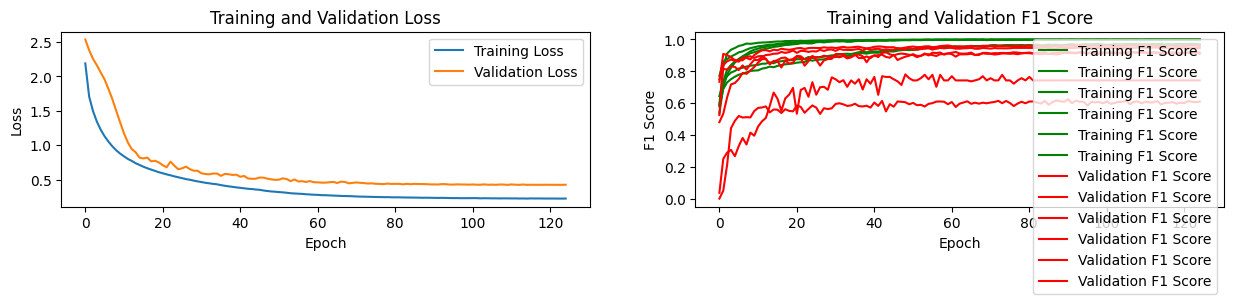

In [4]:
test_cnn_model_2 = cnn_model_2.evaluate(X_validation, y_validation, verbose=1)
print('Test categorical:', test_cnn_model_2[1])
print('Test f1:', test_cnn_model_2[2])

check_results(cnn_model2_history)
bacc_final = bacc(cnn_model_2, X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)

In [8]:
predictions = cnn_model_2.predict(x = test_images, batch_size = 200, verbose = 0)
rounded_predictions = np.argmax(predictions,axis=-1)
number_per_class(rounded_predictions)
np.save('ypredictions_lab4.npy', rounded_predictions)

Número de imagens da  classe 0: 1287
Número de imagens da classe 1: 282
Número de imagens da classe 2: 26
Número de imagens da classe 3: 590
Número de imagens da classe 4: 230
Número de imagens da classe 5: 243


In [ ]:
cnn_model_3, cnn_model3_history = model_3(X_train, y_train)

67/67 [==============================] - 0s 4ms/step - loss: 0.5771 - categorical_accuracy: 0.7018 - f1_score: 0.6329
Test categorical: 0.7017874121665955
Test f1: [0.7743017  0.41545895 0.34710744 0.78215224 0.69581056 0.7823961 ]
Train - Loss: 0.4789
Test  - Val Loss: 0.5896
Train - Mean F1 Score: 0.5634
Test - Mean Val F1 Score: 0.5556
67/67 [==============================] - 0s 3ms/step
Balanced Accuracy: 0.7593901464020311


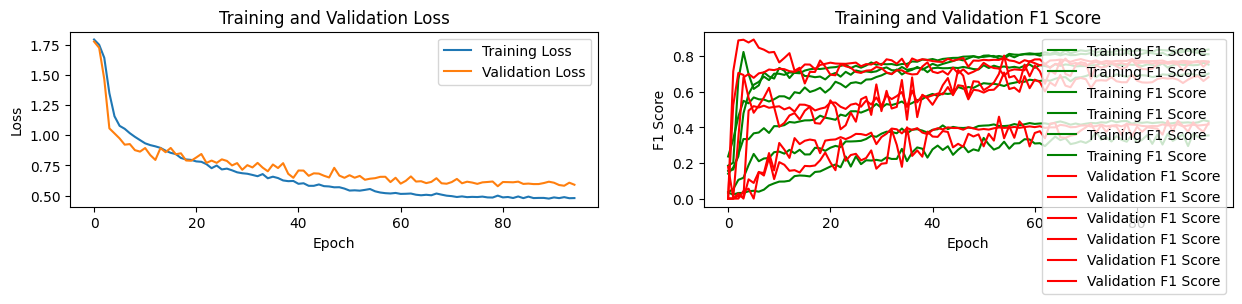

In [ ]:
test_cnn_model_3 = cnn_model_3.evaluate(X_validation, y_validation, verbose=1)
print('Test categorical:', test_cnn_model_3[1])
print('Test f1:', test_cnn_model_3[2])

check_results(cnn_model3_history)
bacc_final = bacc(cnn_model_3, X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)

In [ ]:
cnn_model_4, cnn_model4_history = model_4(X_train, y_train)

67/67 [==============================] - 0s 4ms/step - loss: 0.8225 - categorical_accuracy: 0.8382 - f1_score: 0.7724
Test categorical: 0.8381937742233276
Test f1: [0.8637771  0.52509654 0.5        0.9312289  0.9095238  0.90464544]
Train - Loss: 0.6471
Test  - Val Loss: 0.8282
Train - Mean F1 Score: 0.7874
Test - Mean Val F1 Score: 0.7130
67/67 [==============================] - 0s 3ms/step
Balanced Accuracy: 0.8454285832489733


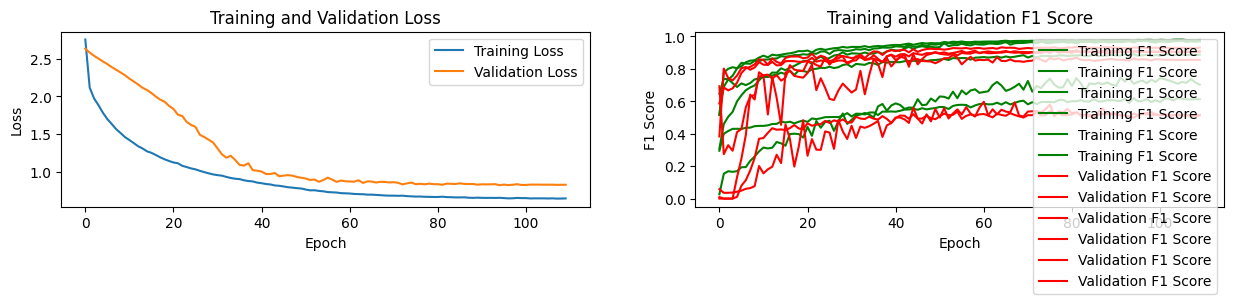

In [ ]:
test_cnn_model_4 = cnn_model_4.evaluate(X_validation, y_validation, verbose=1)
print('Test categorical:', test_cnn_model_4[1])
print('Test f1:', test_cnn_model_4[2])

check_results(cnn_model4_history)
bacc_final = bacc(cnn_model_4, X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)

In [ ]:
cnn_model_5, cnn_model5_history = model_5(X_train, y_train)

67/67 [==============================] - 0s 4ms/step - loss: 0.6968 - categorical_accuracy: 0.8735 - f1_score: 0.8199
Test categorical: 0.8734713196754456
Test f1: [0.8915784  0.6007752  0.6122449  0.9513514  0.92670155 0.9370277 ]
Train - Loss: 0.5647
Test  - Val Loss: 0.6986
Train - Mean F1 Score: 0.8289
Test - Mean Val F1 Score: 0.7606
67/67 [==============================] - 0s 3ms/step
Balanced Accuracy: 0.8651351418020526


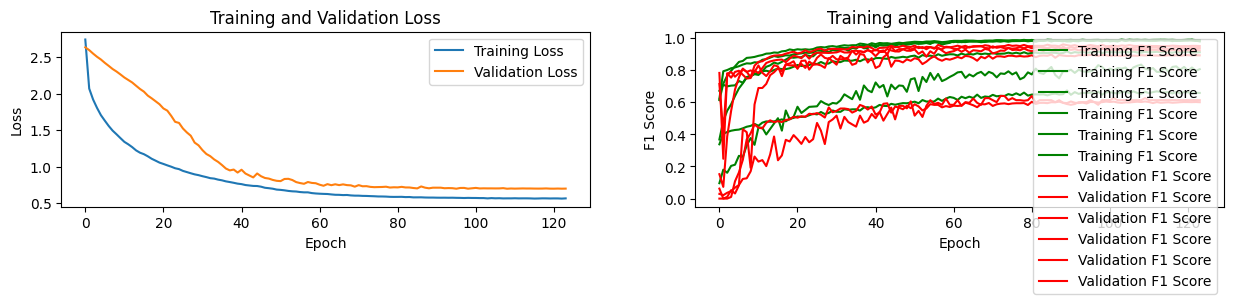

In [ ]:
test_cnn_model_5 = cnn_model_5.evaluate(X_validation, y_validation, verbose=1)
print('Test categorical:', test_cnn_model_5[1])
print('Test f1:', test_cnn_model_5[2])

check_results(cnn_model5_history)
bacc_final = bacc(cnn_model_5, X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)

In [ ]:
models=[cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4, cnn_model_5]
model_history=[cnn_model1_history, cnn_model2_history, cnn_model3_history, cnn_model4_history, cnn_model5_history]

from sklearn.metrics import confusion_matrix

#y_validation = [
# [1, 0, 0],
# [0, 1, 0],
# [0, 0, 1],
# y_true = [0, 1, 2, ...]
def pre_ensemble_model(models, X_validation, y_validation, test_images):
    num_models = len(models)
    y_true = np.argmax(y_validation, axis=1)

    y_pred_test = [None] * num_models
    y_pred_val = [None] * num_models
    results_val = [None] * num_models
    confusion_matrix_val = [None] * num_models

    for i in range(num_models):
        print(f'Model {i + 1}')
        y_pred_test[i] = models[i].predict(test_images)
        y_pred_val[i] = models[i].predict(X_validation)

        np.save(f'Results_model_test{i}', y_pred_test[i])
        results_val[i] = np.argmax(y_pred_val[i], axis=1).copy()
        confusion_matrix_val[i] = confusion_matrix(y_true, results_val[i], normalize='pred')
        print(confusion_matrix_val[i])

    return y_pred_test, y_pred_val, y_true

y_pred_test, y_pred_val, y_true = pre_ensemble_model(models, X_validation, y_validation, test_images)

Model 1
67/67 [==============================] - 0s 3ms/step
[[0.97359357 0.53296703 0.43589744 0.         0.         0.        ]
 [0.02640643 0.46153846 0.07692308 0.         0.         0.        ]
 [0.         0.00549451 0.48717949 0.         0.         0.        ]
 [0.         0.         0.         0.968523   0.15196078 0.17446809]
 [0.         0.         0.         0.02179177 0.83823529 0.0212766 ]
 [0.         0.         0.         0.00968523 0.00980392 0.80425532]]
Model 2
67/67 [==============================] - 0s 3ms/step
[[0.93110048 0.39252336 0.14285714 0.         0.         0.        ]
 [0.06220096 0.59813084 0.         0.         0.         0.00505051]
 [0.00669856 0.00934579 0.85714286 0.         0.         0.        ]
 [0.         0.         0.         0.97408207 0.06770833 0.04040404]
 [0.         0.         0.         0.01079914 0.92708333 0.01010101]
 [0.         0.         0.         0.01511879 0.00520833 0.94444444]]
Model 3
67/67 [==============================] -

In [ ]:
final_pred_val = sum(y_pred_val) / len(y_pred_val) #Ensemble operation
final_pred_val_vector = np.argmax(final_pred_val, axis=1)
confusion_matrix_final = confusion_matrix(y_true, final_pred_val_vector, normalize='pred')
print(confusion_matrix_final)

y_prediction_one_hot_encoded = sum(y_pred_test) / len(y_pred_test)
delivery_results = np.argmax(y_prediction_one_hot_encoded, axis=1)
np.save('file_to_deliver', delivery_results)

[[0.96595745 0.46666667 0.32352941 0.         0.         0.        ]
 [0.03404255 0.53       0.08823529 0.         0.         0.        ]
 [0.         0.00333333 0.58823529 0.         0.         0.        ]
 [0.         0.         0.         0.98423423 0.10784314 0.06372549]
 [0.         0.         0.         0.0045045  0.8872549  0.00980392]
 [0.         0.         0.         0.01126126 0.00490196 0.92647059]]
